<a href="https://colab.research.google.com/github/KhazaeiM/Anomaly_detection/blob/main/03__Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install dgl #-f https://data.dgl.ai/wheels/repo.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux20

In [3]:
!pip install torch==2.1.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 790.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 2.1.0+rocm5.6 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.1.0+rocm5.6 which is incompatible.
torchvision 0.18.0+cu121 requires torch==2.3.0, but you have torch 2.1.0+rocm5.6 which is incompatible.


In [4]:
import numpy as np
import torch as tch
# tch.utils.data.datapipes.utils.common.DILL_AVAILABLE = tch.utils._import_utils.dill_available()
# import torchdata
import dgl
import itertools
import csv
from itertools import chain
import string
import pandas as pd
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as func
import dgl.function as dglfunc
import cv2
from google.colab.patches import cv2_imshow
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [5]:
# tch.__version__

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale

In [7]:
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Layer, LSTM, Bidirectional
from tensorflow.keras.losses import mse
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import losses

In [8]:
data_path = "/content/drive/MyDrive/My_data/Paper/AMiner_Academic/Data/Anomaly_paper/"
dimen = 32
window = 5

In [9]:
# CONVERT str TO list
def str2list(x):
  if (type(x) != float) and (x != "['-']"):
    temp = x.split(', ')
    return [t.translate(str.maketrans('', '', string.punctuation)) for t in temp]
  else:
    return []

In [10]:
# CONVERT TEXT TYPE TO TENSOR TYPE
def txt2array(x):
  temp = x.replace('[', "").replace(']', "").replace('\n', "").split()
  float_list = [float(z) for z in temp]
  return tch.Tensor([float_list])

In [17]:
papers = pd.read_csv(data_path + 'AMiner-Papers-inj-5p-csv.csv', index_col=False)
authors = pd.read_csv(data_path + 'AMiner-Authors-inj-5p-csv.csv', index_col=False)
# venues = pd.read_csv(data_path + 'AMiner-V&A&P-inj-5p-csv.csv', index_col=False)

In [18]:
p_col = ['index_a', 'references', 'venue_name']
a_col = ['index_p', 'venue_name', 'co_authors']
v_col = ['index_a', 'index_p']
for col in p_col:
  papers[col] = papers[col].apply(lambda x: str2list(x))
for col in a_col:
  authors[col] = authors[col].apply(lambda x: str2list(x))
# for col in v_col:
#   venues[col] = venues[col].apply(lambda x: str2list(x))

papers['title'] = papers['title'].apply(lambda x: txt2array(x))
authors['interest'] = authors['interest'].apply(lambda x: txt2array(x))

num_col_a = ['h_index', 'p_index']
for col in num_col_a:
  authors[col] = authors[col].apply(lambda x: tch.Tensor([x]))

temp,codes = pd.factorize(papers['year'])
papers['year'] = temp+1
papers['year'] = papers['year'].apply(lambda x: tch.Tensor([x]))
# venues = venues.iloc[:130]
# venues['type'] = venues['type'].apply(lambda x: int(x))

**NORMALIZATION**

In [19]:
papers.head(2)

,index_p,index_a,title,year,references,venue_name,abnormal
0,p1221037,"[a1573508, a701939]","[[tensor(0.0600), tensor(-0.0932), tensor(-0.0...",[tensor(1.)],[],[],0
1,p1247452,[a1150721],"[[tensor(-0.0290), tensor(-0.0463), tensor(0.0...",[tensor(1.)],[],[],0


In [20]:
p = np.array(papers['title'].to_list()).flatten().reshape((-1,dimen))
norm_p = np.linalg.norm(p)
# papers['title'] = papers['title'].apply(lambda x: x/norm_p)
data = tch.from_numpy(normalize(p, axis=0, norm='max'))
papers['title'] = list(data)
papers.head(2)

,index_p,index_a,title,year,references,venue_name,abnormal
0,p1221037,"[a1573508, a701939]","[tensor(0.1387), tensor(-0.1581), tensor(-0.02...",[tensor(1.)],[],[],0
1,p1247452,[a1150721],"[tensor(-0.0670), tensor(-0.0785), tensor(0.05...",[tensor(1.)],[],[],0


In [21]:
a = np.array(authors['interest'].to_list()).flatten().reshape((-1,dimen))
norm_a = np.linalg.norm(a)
# authors['interest'] = authors['interest'].apply(lambda x: x/norm_a)
data = tch.from_numpy(normalize(a, axis=0, norm='max'))
authors['interest'] = list(data)
authors.head(2)

,index_a,index_p,h_index,p_index,interest,venue_name,co_authors,abnormal
0,a100,[p1853556],[tensor(1.)],[tensor(1.)],"[tensor(-0.1095), tensor(-0.1607), tensor(0.33...",[],[],0
1,a1000000,[p1608103],[tensor(1.)],[tensor(1.)],"[tensor(0.0124), tensor(-0.0852), tensor(0.090...",[],"[a1145211, a937524]",0


**UNITED FEATURE** (LAYER SELF)

In [22]:
authors['embed_feat_a'] = authors.apply(lambda row: tch.hstack((row['interest'], row['h_index'], row['p_index'])), axis=1)
papers['embed_feat_p'] = papers.apply(lambda row: tch.hstack((row['title'], row['year'])), axis=1) #.reshape((1,-1))
embed_a = tch.stack(authors['embed_feat_a'].to_list())
embed_p = tch.stack(papers['embed_feat_p'].to_list())

In [23]:
class AE(tch.nn.Module):
  def __init__(self, in_size):
    super().__init__()
    self.encoder = tch.nn.Sequential(tch.nn.Linear(in_size, 32), tch.nn.ReLU(),
                                     tch.nn.Dropout(0.15),
                                     tch.nn.Linear(32, 16), tch.nn.ReLU(),
                                     tch.nn.Dropout(0.15),
                                     tch.nn.Linear(16, 8), tch.nn.ReLU(),
                                     tch.nn.Dropout(0.15),
                                     tch.nn.Linear(8, 1))

    self.decoder = tch.nn.Sequential(tch.nn.Linear(1, 8), tch.nn.ReLU(),
                                     tch.nn.Dropout(0.15),
                                     tch.nn.Linear(8, 16), tch.nn.ReLU(),
                                     tch.nn.Dropout(0.15),
                                     tch.nn.Linear(16, 32), tch.nn.ReLU(),
                                     tch.nn.Dropout(0.15),
                                     tch.nn.Linear(32, in_size))

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [24]:
model_a = AE(34)
model_p = AE(33)
loss_function = tch.nn.MSELoss()
optimizer_a = tch.optim.Adam(model_a.parameters(), lr = 1e-2, weight_decay = 1e-3, amsgrad=True)
optimizer_p = tch.optim.Adam(model_p.parameters(), lr = 1e-2, weight_decay = 1e-3, amsgrad=True)
epochs = 40

In [25]:
# FOR AUTHORS' FEATURES
# losses = []
for epoch in range(epochs):
  reconstructed_a = model_a(embed_a)
  loss = loss_function(reconstructed_a, embed_a)
  optimizer_a.zero_grad()
  loss.backward()
  optimizer_a.step()
  # losses.append(loss)
print(loss)
new_a = model_a.encoder(embed_a)
# tch.save(model_a, data_path)

tensor(2.2961, grad_fn=<MseLossBackward0>)


In [26]:
# FOR PAPERS' FEATURES
# losses = []
for epoch in range(epochs):
  reconstructed_p = model_p(embed_p)
  loss = loss_function(reconstructed_p, embed_p)
  optimizer_p.zero_grad()
  loss.backward()
  optimizer_p.step()
  # losses.append(loss)
print(loss)
new_p = model_p.encoder(embed_p)
# tch.save(model_p, data_path)

tensor(0.1033, grad_fn=<MseLossBackward0>)


In [27]:
# FOR TEST DATA

# model_p = tch.load(model_p)

In [28]:
authors['a_embed'] = list(tch.tensor(new_a.reshape((-1,1)).detach().numpy()))
authors.head(2)

,index_a,index_p,h_index,p_index,interest,venue_name,co_authors,abnormal,embed_feat_a,a_embed
0,a100,[p1853556],[tensor(1.)],[tensor(1.)],"[tensor(-0.1095), tensor(-0.1607), tensor(0.33...",[],[],0,"[tensor(-0.1095), tensor(-0.1607), tensor(0.33...",[tensor(-0.0421)]
1,a1000000,[p1608103],[tensor(1.)],[tensor(1.)],"[tensor(0.0124), tensor(-0.0852), tensor(0.090...",[],"[a1145211, a937524]",0,"[tensor(0.0124), tensor(-0.0852), tensor(0.090...",[tensor(-0.0630)]


In [29]:
papers['p_embed'] = list(tch.tensor(new_p.reshape((-1,1)).detach().numpy()))
papers.head(2)

,index_p,index_a,title,year,references,venue_name,abnormal,embed_feat_p,p_embed
0,p1221037,"[a1573508, a701939]","[tensor(0.1387), tensor(-0.1581), tensor(-0.02...",[tensor(1.)],[],[],0,"[tensor(0.1387), tensor(-0.1581), tensor(-0.02...",[tensor(0.2295)]
1,p1247452,[a1150721],"[tensor(-0.0670), tensor(-0.0785), tensor(0.05...",[tensor(1.)],[],[],0,"[tensor(-0.0670), tensor(-0.0785), tensor(0.05...",[tensor(0.2294)]


**MAKE GRAPH**

In [30]:
papers['idx_p'] = [i for i in range(len(papers['index_p']))]
authors['idx_a'] = [i for i in range(len(authors['index_a']))]

In [31]:
papers_ex_a = papers.explode(['index_a'], ignore_index= True).reset_index(drop=True)
papers_ex_a_mg = papers_ex_a.merge(authors, how='left', on='index_a')
papers_ex_a_mg.tail(1)

,index_p_x,index_a,title,year,references,venue_name_x,abnormal_x,embed_feat_p,p_embed,idx_p,index_p_y,h_index,p_index,interest,venue_name_y,co_authors,abnormal_y,embed_feat_a,a_embed,idx_a
688711,p935104,a527608,"[tensor(-0.1990), tensor(-0.1119), tensor(0.12...",[tensor(1.)],[],[],0,"[tensor(-0.1990), tensor(-0.1119), tensor(0.12...",[tensor(0.2307)],137771,[p935104],[tensor(2.)],[tensor(13.2500)],"[tensor(-0.1761), tensor(-0.0537), tensor(0.07...",[],[],0,"[tensor(-0.1761), tensor(-0.0537), tensor(0.07...",[tensor(8.2325)],76980


In [32]:
papers_ex_p = papers.explode(['references'], ignore_index= True).reset_index(drop=True)
papers_ex_p_mg = papers_ex_p.merge(papers, left_on='references', right_on='index_p')
papers_ex_p_mg.tail(1)

,index_p_x,index_a_x,title_x,year_x,references_x,venue_name_x,abnormal_x,embed_feat_p_x,p_embed_x,idx_p_x,index_p_y,index_a_y,title_y,year_y,references_y,venue_name_y,abnormal_y,embed_feat_p_y,p_embed_y,idx_p_y
572340,p2085557,"[a1074831, a1519682]","[tensor(0.0762), tensor(-0.0367), tensor(0.267...",[tensor(4.)],p1993683,[],0,"[tensor(0.0762), tensor(-0.0367), tensor(0.267...",[tensor(0.2328)],137174,p1993683,[a325137],"[tensor(0.1603), tensor(-0.0878), tensor(0.118...",[tensor(4.)],[],[],0,"[tensor(0.1603), tensor(-0.0878), tensor(0.118...",[tensor(0.2295)],117539


In [33]:
authors_ex_a = authors.explode(['co_authors'], ignore_index= True).reset_index(drop=True)
authors_ex_a_mg = authors_ex_a.merge(authors, left_on='co_authors', right_on='index_a')
authors_ex_a_mg.tail(1)

,index_a_x,index_p_x,h_index_x,p_index_x,interest_x,venue_name_x,co_authors_x,abnormal_x,embed_feat_a_x,a_embed_x,...,index_p_y,h_index_y,p_index_y,interest_y,venue_name_y,co_authors_y,abnormal_y,embed_feat_a_y,a_embed_y,idx_a_y
498805,a997788,[p1615256],[tensor(1.)],[tensor(0.8000)],"[tensor(0.0739), tensor(-0.1094), tensor(0.333...",[],a999690,0,"[tensor(0.0739), tensor(-0.1094), tensor(0.333...",[tensor(-0.0674)],...,[p1615256],[tensor(1.)],[tensor(0.8000)],"[tensor(0.0258), tensor(-0.1170), tensor(0.358...",[],[],0,"[tensor(0.0258), tensor(-0.1170), tensor(0.358...",[tensor(-0.0293)],111356


In [34]:
a_a_src = authors_ex_a_mg['idx_a_x'].to_list()
a_a_dist = authors_ex_a_mg['idx_a_y'].to_list()

p_p_src = papers_ex_p_mg['idx_p_x'].to_list()
p_p_dist = papers_ex_p_mg['idx_p_y'].to_list()

p_a_src = papers_ex_a_mg['idx_p'].to_list()
p_a_dist = papers_ex_a_mg['idx_a'].to_list()

In [35]:
a_feat_interest = tch.vstack(authors['interest'].to_list())
a_feat_pidx = tch.vstack(authors['p_index'].to_list())
a_feat_hidx = tch.vstack(authors['h_index'].to_list()).type(tch.float32)
a_embed = tch.vstack(authors['a_embed'].to_list())

p_embed = tch.vstack(papers['p_embed'].to_list())
p_feat_title = tch.vstack(papers['title'].to_list())
p_feat_year = tch.vstack(papers['year'].to_list()).type(tch.float32)

In [36]:
het_data = {('auth', 'co_auth', 'auth'): (tch.tensor(a_a_src), tch.tensor(a_a_dist)),
            ('pap', 'cite', 'pap'): (tch.tensor(p_p_src), tch.tensor(p_p_dist)),
            ('pap', 'write', 'auth'): (tch.tensor(p_a_src), tch.tensor(p_a_dist))}
het_graph = dgl.heterograph(het_data)
het_graph

Graph(num_nodes={'auth': 111387, 'pap': 137772},
      num_edges={('auth', 'co_auth', 'auth'): 498806, ('pap', 'cite', 'pap'): 572341, ('pap', 'write', 'auth'): 688712},
      metagraph=[('auth', 'auth', 'co_auth'), ('pap', 'pap', 'cite'), ('pap', 'auth', 'write')])

In [37]:
het_graph.nodes['auth'].data['interest'] = a_feat_interest
het_graph.nodes['auth'].data['p_index'] = a_feat_pidx
het_graph.nodes['auth'].data['h_index'] = a_feat_hidx
het_graph.nodes['auth'].data['a_embed'] = a_embed
het_graph.nodes['pap'].data['p_embed'] = p_embed
het_graph.nodes['pap'].data['title'] = p_feat_title
het_graph.nodes['pap'].data['year'] = p_feat_year

**LAYER SAME** : GCN for each type and aggregate

In [38]:
homo_auth = het_graph.node_type_subgraph(['auth'])
homo_auth

Graph(num_nodes=111387, num_edges=498806,
      ndata_schemes={'interest': Scheme(shape=(32,), dtype=torch.float32), 'p_index': Scheme(shape=(1,), dtype=torch.float32), 'h_index': Scheme(shape=(1,), dtype=torch.float32), 'a_embed': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})

In [39]:
homo_auth_bi = dgl.to_bidirected(homo_auth, copy_ndata=True)
homo_auth_bi

Graph(num_nodes=111387, num_edges=589531,
      ndata_schemes={'interest': Scheme(shape=(32,), dtype=torch.float32), 'p_index': Scheme(shape=(1,), dtype=torch.float32), 'h_index': Scheme(shape=(1,), dtype=torch.float32), 'a_embed': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})

In [40]:
class GCN(nn.Module):
  def __init__(self, in_size, out_size):
    super().__init__()
    self.gcn = dglnn.GraphConv(in_size, out_size, norm='both', weight=True, bias=True, allow_zero_in_degree=False)

  def forward(self, graph, feat):
    h = self.gcn(graph, feat)
    h = func.relu(h)
    # h = self.gcn(graph, h)
    h = self.gcn(graph, h)
    # h = func.relu(h)
    # h = {k: func.relu(v) for k, v in h.items()}
    # h = {k: v.mean(axis=0) for k, v in h.items()}
    return h

In [41]:
homo_auth_bi = dgl.remove_self_loop(homo_auth_bi)
homo_auth_bi = dgl.add_self_loop(homo_auth_bi)

In [42]:
feat_a = tch.hstack((homo_auth_bi.nodes['auth'].data['interest'], homo_auth_bi.nodes['auth'].data['h_index'],
                              homo_auth_bi.nodes['auth'].data['p_index']))
feat_a.shape

torch.Size([111387, 34])

In [43]:
model = GCN(34,34)
opt = tch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.8, 0.9), eps=1e-9, weight_decay=1e-02, amsgrad=True)

for epoch in range(30):
  model.train()
  pred = model(homo_auth_bi, feat_a)
  loss = func.smooth_l1_loss(pred, feat_a)
  opt.zero_grad()
  loss.backward()
  opt.step()
print(loss.item())

0.09274818748235703


In [44]:
feat_same_auth = model(homo_auth_bi, feat_a)
feat_same_auth[0]

tensor([-0.0205, -0.0671,  0.1245,  0.1543, -0.1237, -0.0821,  0.1216,  0.2076,
        -0.1664, -0.0433,  0.0823, -0.1621,  0.0376,  0.0151, -0.1203, -0.1140,
         0.0703,  0.0824, -0.1288,  0.0369,  0.2435,  0.1765,  0.2135, -0.1583,
         0.0249, -0.0258, -0.0718,  0.1894, -0.1931, -0.0873, -0.0545, -0.0665,
         1.0242,  0.9815], grad_fn=<SelectBackward0>)

In [45]:
epochs = 40

In [46]:
model_rd_a = AE(34)
loss_function = tch.nn.MSELoss()
optimizer_a = tch.optim.Adam(model_rd_a.parameters(), lr=1e-2, betas=(0.4, 0.9), eps=1e-9, weight_decay = 1e-3, amsgrad=True)
# losses = []
for epoch in range(epochs):
  reconstructed_a = model_rd_a(feat_same_auth.detach())
  loss = loss_function(reconstructed_a, feat_same_auth.detach())
  optimizer_a.zero_grad()
  loss.backward()
  optimizer_a.step()
  # losses.append(loss)
print(loss)
same_a_rd = model_rd_a.encoder(feat_same_auth)

tensor(0.2534, grad_fn=<MseLossBackward0>)


In [47]:
authors['feat_a_same'] = list(tch.tensor(same_a_rd.detach().numpy()))

In [48]:
homo_pap = het_graph.node_type_subgraph(['pap'])
homo_pap_bi = dgl.to_bidirected(homo_pap, copy_ndata=True)
homo_pap_bi

Graph(num_nodes=137772, num_edges=573354,
      ndata_schemes={'p_embed': Scheme(shape=(1,), dtype=torch.float32), 'title': Scheme(shape=(32,), dtype=torch.float32), 'year': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})

In [49]:
feat_p = tch.hstack((homo_pap_bi.nodes['pap'].data['title'], homo_pap_bi.nodes['pap'].data['year']))#,
                              # homo_pap_bi.nodes['pap'].data['year']))
feat_p.shape

torch.Size([137772, 33])

In [50]:
homo_pap_bi = dgl.remove_self_loop(homo_pap_bi)
homo_pap_bi = dgl.add_self_loop(homo_pap_bi)

In [51]:
model = GCN(33,33)
opt = tch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.4, 0.9), eps=1e-7, weight_decay=1e-02, amsgrad=True)

for epoch in range(30):
  model.train()
  pred = model(homo_pap_bi, feat_p)
  loss = func.l1_loss(pred, feat_p)
  opt.zero_grad()
  loss.backward()
  opt.step()
print(loss.item())

0.09611961990594864


In [52]:
feat_same_pap = model(homo_pap_bi, feat_p)
feat_same_pap[0]

tensor([ 2.5042e-02, -9.3822e-02,  8.4443e-02,  4.9173e-02,  4.8709e-02,
        -7.6217e-02,  1.1172e-01, -9.8599e-02, -9.3696e-02,  6.8891e-03,
         3.4992e-02, -8.7489e-02, -3.2059e-02, -4.8937e-02, -4.4092e-02,
        -5.6675e-03, -1.1833e-01,  6.6986e-02,  3.1539e-02,  1.1573e-01,
         9.3312e-02,  7.3880e-02,  7.5549e-02, -8.1204e-02,  5.8966e-04,
         1.8531e-02, -1.0583e-01, -3.0710e-03, -4.7345e-02, -1.9382e-02,
        -3.6771e-02,  6.5453e-02,  1.1806e+00], grad_fn=<SelectBackward0>)

In [53]:
# losses = []
model_rd_p = AE(33)
optimizer_p = tch.optim.Adam(model_rd_p.parameters(), lr = 1e-2, weight_decay = 1e-3, amsgrad=True)

for epoch in range(epochs):
  reconstructed_p = model_rd_p(feat_same_pap.detach())
  loss = loss_function(reconstructed_p, feat_same_pap.detach())
  optimizer_p.zero_grad()
  loss.backward()
  optimizer_p.step()
  # losses.append(loss)
print(loss)
same_p_rd = model_rd_p.encoder(feat_same_pap.detach())

tensor(0.0457, grad_fn=<MseLossBackward0>)


In [54]:
papers['feat_p_same'] = list(tch.tensor(same_p_rd.detach().numpy()))

**LAYER DIFF** (MESSAGE PASSING)

In [55]:
het_graph.multi_update_all({'write':(dglfunc.u_add_v('p_embed', 'a_embed', 'msg_write'), dglfunc.sum('msg_write', 'diff_msg')),
                            'cite':(dglfunc.u_add_v('p_embed', 'p_embed', 'msg_cite'), dglfunc.sum('msg_cite', 'diff_msg')),
                            'co_auth':(dglfunc.u_add_v('a_embed', 'a_embed', 'msg_co_auth'), dglfunc.sum('msg_co_auth', 'diff_msg'))
                      },'sum')

In [56]:
diff_feat_a = list(het_graph.ndata['diff_msg']['auth'])
diff_feat_p = list(het_graph.ndata['diff_msg']['pap'])
authors['diff_feat'] = diff_feat_a
papers['diff_feat'] = diff_feat_p
authors.head(1)

,index_a,index_p,h_index,p_index,interest,venue_name,co_authors,abnormal,embed_feat_a,a_embed,idx_a,feat_a_same,diff_feat
0,a100,[p1853556],[tensor(1.)],[tensor(1.)],"[tensor(-0.1095), tensor(-0.1607), tensor(0.33...",[],[],0,"[tensor(-0.1095), tensor(-0.1607), tensor(0.33...",[tensor(-0.0421)],0,[tensor(0.2560)],[tensor(0.1917)]


In [57]:
a_an = authors[authors['abnormal'] == 1]

In [58]:
a_an.iloc[0]

index_a                                                  a1000110
index_p                                                [p1614531]
h_index                                              [tensor(5.)]
p_index                                         [tensor(32.3020)]
interest        [tensor(0.0878), tensor(0.0250), tensor(0.2079...
venue_name                                                     []
co_authors                                                     []
abnormal                                                        1
embed_feat_a    [tensor(0.0878), tensor(0.0250), tensor(0.2079...
a_embed                                         [tensor(18.7435)]
idx_a                                                          23
feat_a_same                                     [tensor(-5.6504)]
diff_feat                                       [tensor(18.9731)]
Name: 23, dtype: object

In [59]:
# authors.to_csv(data_path + 'AMiner-Authors-5p-embed-csv.csv', encoding="utf8", index=False)
# papers.to_csv(data_path + 'AMiner-Papers-5p-embed-csv.csv', encoding="utf8", index=False)

**IMAGE**

In [60]:
len(papers['index_p'])

137772

In [61]:
len(authors['index_a'])

111387

In [62]:
auth_mx = np.stack((authors['a_embed'], authors['feat_a_same'], authors['diff_feat']), axis=1)
auth_mx = auth_mx.reshape((-1,1,3)).astype(float)
auth_mx.shape

(111387, 1, 3)

In [63]:
a_image = cv2.normalize(auth_mx, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
a_image = np.array(a_image, dtype=np.uint8)
# cv2_imshow(a_image)

In [64]:
unique_a, counts_a = np.unique(a_image, return_counts=True)
print(unique_a, counts_a)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  23  24  27  28  31  32  38  41  42  50  83 130 189 255] [     2    803 332212    762    153     65     47     18     22     14
     17      6      1      1      2      3      4      4      1      3
      1      3      1      2      1      1      2      1      1      1
      1      2      1      1      1      1]


In [65]:
# max_occurance_a = unique_a[np.where(counts_a == counts_a.max())[0][0]]
max_occurance_a = unique_a[np.where(counts_a <= np.quantile(counts_a, 0.95))[0][0]]
temp_pos_a = np.where(a_image != max_occurance_a)
temp_pos_a

(array([     0,      0,      0, ..., 111386, 111386, 111386]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [ ]:
t = unique_a[counts_a >= np.quantile(counts_a, 0.95)]
print(t)
# temp_pos_a = np.where(a_image != )
# print(temp_pos_a)
# np.unique(temp_pos_a[0])

[249 250 251]


In [ ]:
pos = a_image in(t)
pos

True

In [ ]:
q1 = np.quantile(counts_a, 0.85)
q2 = np.quantile(counts_a, 0.90)
q3 = np.quantile(counts_a, 0.95)

print(q1, q2, q3)

40.850000000000016 73.49999999999997 1594.9499999999894


In [ ]:
# WHY?
# temp[1].max() == 0

In [ ]:
abnormal_a = authors.iloc[np.unique(temp_pos_a[0])]
normal_a = authors.loc[authors.index.difference(abnormal_a.index)]

In [ ]:
len(abnormal_a['abnormal'])

111387

In [ ]:
len(normal_a['abnormal'])

0

In [ ]:
total_a = len(authors['index_a'])

expected_pos_a = abnormal_a['index_a'].to_list()
expected_neg_a = normal_a['index_a'].to_list()

real_pos_a_lst = authors[authors['abnormal'] == 1]['index_a'].to_list()
real_neg_a_lst = authors[authors['abnormal'] == 0]['index_a'].to_list()

ex_pos = len(expected_pos_a)
ex_neg = len(expected_neg_a)
real_pos_a = len(real_pos_a_lst)
real_neg_a = len(real_neg_a_lst)

print('Expected_pos:', ex_pos)
print('Real_pos:', real_pos_a)

TP_a=0
FP_a=0
for ex in expected_pos_a:
  if ex in real_pos_a_lst:
    TP_a+=1
  else:
    FP_a+=1
TN_a=0
FN_a=0
for ex in expected_neg_a:
  if ex in real_neg_a_lst:
    TN_a+=1
  else:
    FN_a+=1

print('True Positive:', TP_a)
print('True Negative:', TN_a)
print('False Negative:', FN_a)
print('False Positive:', FP_a)

accuracy_a = (TP_a+TN_a)/(total_a)
recall_a = TP_a/real_pos_a
sensitivity_a = TP_a/(TP_a+FN_a)
specificity_a = TN_a/(TN_a+FP_a)
print(accuracy_a, recall_a, sensitivity_a, specificity_a)

Expected_pos: 10223
Real_pos: 5635
True Positive: 5123
True Negative: 100652
False Negative: 512
False Positive: 5100
0.9496171007388654 0.9091393078970719 0.9091393078970719 0.9517739617217641


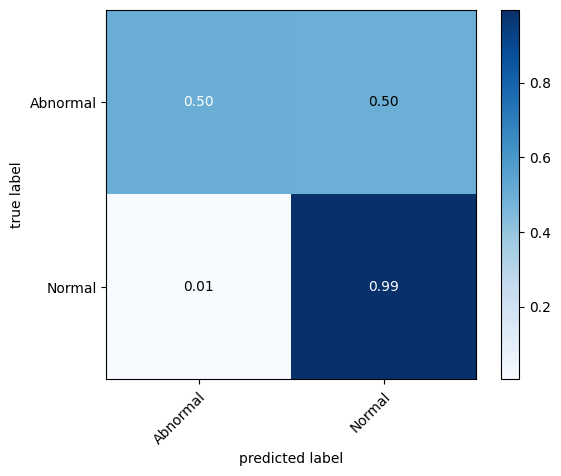

In [ ]:
cm = np.array([[TP_a, FP_a],
               [FN_a, TN_a]])

classes = ['Abnormal', 'Normal']
figure, ax = plot_confusion_matrix(conf_mat = cm, class_names = classes, show_absolute = False, colorbar = True, show_normed = True)
plt.show()

In [ ]:
pap_mx = np.stack((papers['p_embed'], papers['feat_p_same'], papers['diff_feat']), axis=1)
pap_mx = pap_mx.reshape((-1,3,3)).astype(float)
p_image = cv2.normalize(pap_mx, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
p_image = np.array(p_image, dtype=np.uint8)
# cv2_imshow(p_image)

In [ ]:
unique_p, counts_p = np.unique(p_image, return_counts=True)
print(unique_p, counts_p)

[  0   1   2   3  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 107 108 109 110 111 112 113 114 115 116 117 118 121 123
 129 130 194 195 196 197 198 199 200 201 202 203 205 206 207 208 209 211
 212 213 214 215 216 217 218 219 220 222 223 224 225 226 228 231 233 236
 237 238 239 245 246 251 252 254 255] [271872    263  33029 104765      1     38     40     26     16     64
    257    254    209     97    153    415    225    167     27    109
      7      3    153     53     69      9     13     26    131    186
     38      4     15      1     11      4     40      2      3      1
      5      4      4      1     24     19     16     16     38     28
      5      2      2     92     20      5     29     22      9      5
      6     28      4      4     19      6     16      1     12      5
      3     21      9      1     30      1      1      2      3      1
      1]


In [ ]:
max_occurance_p = unique_p[np.where(counts_p == counts_p.max())[0][0]]
temp_pos_p = np.where(p_image != max_occurance_p)
# temp_pos_p = np.where((p_image != 0) | (p_image != 1))
temp_pos_p

(array([    0,     0,     0, ..., 45923, 45923, 45923]),
 array([0, 1, 2, ..., 0, 1, 2]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [ ]:
abnormal_p = papers.iloc[np.unique(temp_pos_p)]
normal_p = papers.loc[papers.index.difference(abnormal_p.index)]

In [ ]:
len(abnormal_p['abnormal'])

45924

In [ ]:
len(normal_p['abnormal'])

91848

In [ ]:
total_p = len(papers['index_p'])

expected_pos_p = abnormal_p['index_p'].to_list()
expected_neg_p = normal_p['index_p'].to_list()

real_pos_p_lst = papers[papers['abnormal'] == 1]['index_p'].to_list()
real_neg_p_lst = papers[papers['abnormal'] == 0]['index_p'].to_list()

ex_pos_p = len(expected_pos_p)
ex_neg = len(expected_neg_p)
real_pos_p = len(real_pos_p_lst)
real_neg_p = len(real_neg_p_lst)

print('Expected_pos:', ex_pos_p)
print('Real_pos:', real_pos_p)

TP_p=0
FP_p=0
for ex in expected_pos_p:
  if ex in real_pos_p_lst:
    TP_p+=1
  else:
    FP_p+=1
TN_p=0
FN_p=0
for ex in expected_neg_p:
  if ex in real_neg_p_lst:
    TN_p+=1
  else:
    FN_p+=1

print('True Positive:', TP_p)
print('True Negative:', TN_p)
print('False Negative:', FN_p)
print('False Positive:', FP_p)

accuracy_p = (TP_p+TN_p)/(total_p)
recall_p = TP_p/real_pos_p
sensitivity_p = TP_p/(TP_p+FN_p)
specificity_p = TN_p/(TN_p+FP_p)
print(accuracy_p, recall_p, sensitivity_p, specificity_p)

Expected_pos: 45924
Real_pos: 6845
True Positive: 2350
True Negative: 87353
False Negative: 4495
False Positive: 43574
0.6510974653775804 0.34331628926223523 0.34331628926223523 0.6671885860059422


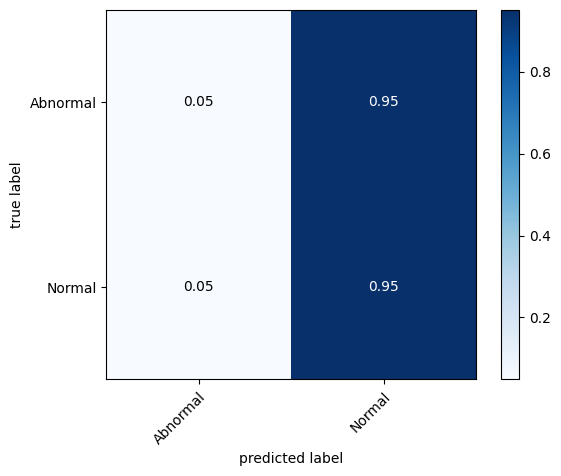

In [ ]:
cm_p = np.array([[TP_p, FP_p],
               [FN_p, TN_p]])

classes = ['Abnormal', 'Normal']
figure, ax = plot_confusion_matrix(conf_mat = cm_p, class_names = classes, show_absolute = False, colorbar = True, show_normed = True)
plt.show()